# Twitter-Bitcoin Correlation Analysis

## 1. Correlation with Sentimental Data & Price of Bitcoin

- Bitcoin 가격과 김도영 학우가 만든 전처리기, 감성분석기를 이용해 상관관계를 확인하기 전 데이터에 대한 분석을 진행하였습니다. 

### 1.1 필요한 라이브러리 import

In [2]:
# nltk 활용을 위한 불용어 다운로드
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kimjuwon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import pandas as pd
from sentimentalAnalysis import sentimental_analysis
import matplotlib.pyplot as plt
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from coincrawler import coin_crawl_his
from data_pipeline import coin_data_pipeline
from data_concat import data_concat
from Greed_Fear_Model import Greed_Fear_Model
import statsmodels.api as sm 
import numpy as np

### 1.2 필요한 데이터 로드 

- Bitcoin_tweet.csv 파일을 로드하고 해당 어트리뷰트는 무엇인지 데이터 수 등 파악
- 'text'라는 컬럼부분을 'tweet'으로 바꿈 
- 데이터를 파악하여 칼럼 값에 결측치가 있는 것을 확인하였음. 결측치가 있을 경우 학습이 안될 가능성이 높고, compile이 되지 않을 가능성이 높으므로 해당값을 제거해주는 방식으로 코딩을 진행하였음

In [205]:
import pandas as pd
from sentimentalAnalysis import sentimental_analysis
import matplotlib.pyplot as plt
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from coincrawler import coin_crawl_his
from data_pipeline import coin_data_pipeline
from data_concat import data_concat
import statsmodels.api as sm 
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

class sentimental_score():
    def __init__(twitter_csv):
        self.twitter_csv = None
    
    def make_greed_fear_score():
        twitter_csv['Greed_Fear_Score']=twitter_csv['vader']*50 +twitter_csv['textblob']*50
        
    def show_monthly_score(self, year,month):
        count = 0
        
        if 'date' in twitter_csv.columns :
            if month < 10 : 
                month = '0'+str(month)
            year = str(year)
            check_monthly = year+'-'+month
        for i in range(len(self.twitter_csv)):
            if self.twitter_csv['date'].iloc[i][:8]==check_monthly:
                print(self.twitter_csv['Greed_fear_Score'].iloc[i])
        else : 
            print("this is not twitter_data")
        print("데이터 수: ",count)
            
class Greed_Fear_Model:
    def __init__(self,tweet_train=None, tweet_test=None):
        self.tweet_train = tweet_train
        self.tweet_test = tweet_test
        self.coin_data = None
        self.train_daily_score = None
        self.test_daily_score = None
        self.normed_train_data = None
        self.normed_test_data = None
        self.model = None
        
    # train_data, test_data set 결측치 제거 및 분석 도구
    def train_check_missing_value(self):
        return self.tweet_train.isna().sum()
        
    def train_fillna(self,f):
        return self.tweet_train.filna(f)
    
    def train_shape(self):
        return self.tweet_train.shape
    
    def train_dtypes(self):
        return self.tweet_train.dtypes
    
    def test_check_missing_value(self):
        return self.tweet_test.isna().sum()
    
    def test_fillna(self,f):
        return self.tweet_test.filna(f)
    
    def test_shape(self):
        return self.tweet_test.shape
        
    def coin_data_load(self,name):
        # data_load
        c_crawler = coin_crawl_his(name)
        c_crawler.startDriver()
        c_crawler.load_page_data()
        self.coin_data = c_crawler.get_data()
        c_crawler.quit_driver()
        # data_convert
        coin_converter = coin_data_pipeline(self.coin_data)
        self.coin_data = coin_converter.convert_for_analysis()
        # dtype지정
        self.coin_data = self.coin_data.astype({'open' : 'float64','close':'float64',
                                                'vol':'float64','low':'float64',
                                                'high':'float64','market cap':'float64'})
        return self.coin_data
    
    def convert_train_data(self,textblob_vader_train=None, flair_train=None):
        new_twitter_data = pd.merge(left = self.tweet_train , 
                                    right = textblob_vader_train[['vader','textblob']], 
                                    how = "inner", left_index = True, right_index=True)
        print(new_twitter_data.shape)
        new_twitter_data = pd.merge(left = new_twitter_data, right = flair_train["flair"], 
                                    left_index =True, right_index=True)
        print(new_twitter_data.shape)
        new_twitter_data = new_twitter_data.drop_duplicates()
        new_twitter_data = new_twitter_data.fillna(0)
        print(new_twitter_data.isna().sum())
        data_date = dict()
        for i in tqdm.notebook.tqdm(range(len(new_twitter_data))):
            row = new_twitter_data.iloc[i]
            key = str(new_twitter_data.iloc[i]['date'][:10])
            if len(row['date']) ==25:
                if len(str(row['follower_number'])) <= 11 and len(str(row['following_number'])) <= 11 and len(str(row['likes'])) <= 11:
                    if row['follower_number'] == 'False' : 
                        row['follower_number'] =0 
                    if row['following_number'] == 'False' : 
                        row['following_number'] = 0
                    if row['likes'] == 'False' : 
                        row['likes'] =0 
                    if key in data_date : 
                        data_date[key][0] += len(row['tweet']) 
                        data_date[key][1] += row['vader']
                        data_date[key][2] += row['textblob']
                        data_date[key][3] += 1
                        data_date[key][4] += int(float(row['follower_number']))
                        data_date[key][5] += int(float(row['following_number']))
                        data_date[key][6] += int(float(row['likes']))
                        data_date[key][7] += (row['flair'])
                    else : 
                        data_date[key] = [ len(row['tweet']), row['vader'], row['textblob'], 1, 
                                        int(float(row['follower_number'])),int(float(row['following_number'])),
                                        int(float(row['likes'])),row['flair'] ]
                        
                            
        data_datelist = []
        data_tweetlength = []
        data_date_vader_sum = []
        data_date_vader_avg = []
        data_date_textblob_sum = []
        data_date_textblob_avg = []
        data_date_count = []
        data_date_following_number_sum = []
        data_date_following_number_avg = []
        data_date_likes_sum = []
        data_date_likes_avg = []
        data_date_follower_number_sum = []
        data_date_follower_number_avg = []
        data_date_flair_sum = []
        data_date_flair_avg = []

        for key in tqdm.notebook.tqdm(data_date):
            data_datelist.append(key)
            data_tweetlength.append(data_date[key][0])
            data_date_vader_sum.append(data_date[key][1])
            data_date_vader_avg.append(data_date[key][1]/data_date[key][3])
            data_date_textblob_sum.append(data_date[key][2])
            data_date_textblob_avg.append(data_date[key][2]/data_date[key][3])
            data_date_flair_sum.append(data_date[key][7])
            data_date_flair_avg.append(data_date[key][7]/data_date[key][3])
            data_date_follower_number_sum.append(data_date[key][4])
            data_date_follower_number_avg.append(data_date[key][4]/data_date[key][3])
            data_date_following_number_sum.append(data_date[key][5])
            data_date_following_number_avg.append(data_date[key][5]/data_date[key][3])
            data_date_likes_sum.append(data_date[key][6])
            data_date_likes_avg.append(data_date[key][6]/data_date[key][3])
            data_date_count.append(data_date[key][3])
                
        sentimental_daily_score = pd.DataFrame({'date': data_datelist, 
                                        'tweet_length': data_tweetlength, 
                                        'vader_sum': data_date_vader_sum,
                                        'vader_avg':data_date_vader_avg,
                                        'textblob_sum': data_date_textblob_sum, 
                                        'textblob_avg':data_date_textblob_avg,
                                        'flair_sum': data_date_flair_sum,
                                        'flair_avg':data_date_flair_avg,
                                        'following_number_sum':data_date_following_number_sum,
                                        'following_number_avg':data_date_following_number_avg,
                                        'likes_sum':data_date_likes_sum,
                                        'likes_avg':data_date_likes_avg,
                                        'follower_number_sum':data_date_follower_number_sum,
                                        'follower_number_avg':data_date_follower_number_sum,
                                        'count':data_date_count
                                       })
        sentimental_daily_score_with_price = pd.merge(left = sentimental_daily_score , right = self.coin_data, 
                                              how = "inner", on = ["date"])
        target_date =[]
        length = sentimental_daily_score_with_price.shape[0]
        for i in tqdm.notebook.tqdm(range(length)):
            date=sentimental_daily_score_with_price.iloc[i]['date']
            year = int(date[:4])
            month = int(date[5:7])
            day = int(date[8:])+1
            if day >= 29 : 
                if month == 2 : 
                    if ((year%4 == 0 and year%100 != 0) or year%400 == 0):
                        day-=29
                        month+=1
                    else : 
                        day-=28
                        month+=1
                elif month in [1,3,5,7,8,10] and day>= 32: 
                    month+=1
                    day-=31
                elif month in [4,6,9,11] and day>=31:
                    month+=1
                    day-=30
                elif month ==12 and day>= 32: 
                    month=1
                    day-=31
            if day < 10 :
                day = '0'+str(day)
            if month < 10 : 
                month = '0'+str(month)

            new_date = str(year)+'-'+str(month)+'-'+str(day)
            target_date.append(new_date)
        sentimental_daily_score_with_price['target_date'] = target_date
            
        Coin_Target_Price = self.coin_data.rename(columns = {'date':'target_date',
                                                      'close' : 'target_close', 'open':'target_open',
                                                      'high':'target_high','low':'target_low',
                                                      'vol':'target_vol', 'market cap':'target_market cap'})
        sentimental_daily_score_with_price = pd.merge(left = sentimental_daily_score_with_price , 
                                                          right = Coin_Target_Price, 
                                                          how = "inner", 
                                                          on = ["target_date"])
        self.train_daily_score = sentimental_daily_score_with_price
        return self.train_daily_score
        
    def convert_test_data(self,textblob_vader_test=None, flair_test=None):
         
        new_twitter_data = pd.merge(left = self.tweet_test , 
                                    right = textblob_vader_test[['vader','textblob']], 
                                    how = "inner", left_index = True, right_index=True)
        new_twitter_data = pd.merge(left = new_twitter_data, right = flair_test["flair"], 
                                    left_index =True, right_index=True)
        new_twitter_data = new_twitter_data.drop_duplicates()
        new_twitter_data = new_twitter_data.fillna(0)
        print(new_twitter_data.isna().sum())
        data_date = dict()
        for i in tqdm.notebook.tqdm(range(len(new_twitter_data))):
            row = new_twitter_data.iloc[i]
            key = str(new_twitter_data.iloc[i]['date'][:10])
            if len(row['date']) ==25:
                if len(str(row['follower_number'])) <= 11 and len(str(row['following_number'])) <= 11 and len(str(row['likes'])) <= 11:
                    if row['follower_number'] == 'False' : 
                        row['follower_number'] =0 
                    if row['following_number'] == 'False' : 
                        row['following_number'] = 0
                    if row['likes'] == 'False' : 
                        row['likes'] =0 
                    if key in data_date : 
                        data_date[key][0] += len(row['tweet']) 
                        data_date[key][1] += row['vader']
                        data_date[key][2] += row['textblob']
                        data_date[key][3] += 1
                        data_date[key][4] += int(float(row['follower_number']))
                        data_date[key][5] += int(float(row['following_number']))
                        data_date[key][6] += int(float(row['likes']))
                        data_date[key][7] += (row['flair'])
                    else : 
                        data_date[key] = [ len(row['tweet']), row['vader'], row['textblob'], 1, 
                                          int(float(row['follower_number'])),int(float(row['following_number'])),
                                          int(float(row['likes'])),row['flair'] ]
                            
        data_datelist = []
        data_tweetlength = []
        data_date_vader_sum = []
        data_date_vader_avg = []
        data_date_textblob_sum = []
        data_date_textblob_avg = []
        data_date_count = []
        data_date_following_number_sum = []
        data_date_following_number_avg = []
        data_date_likes_sum = []
        data_date_likes_avg = []
        data_date_follower_number_sum = []
        data_date_follower_number_avg = []
        data_date_flair_sum = []
        data_date_flair_avg = []

        for key in tqdm.notebook.tqdm(data_date):
            data_datelist.append(key)
            data_tweetlength.append(data_date[key][0])
            data_date_vader_sum.append(data_date[key][1])
            data_date_vader_avg.append(data_date[key][1]/data_date[key][3])
            data_date_textblob_sum.append(data_date[key][2])
            data_date_textblob_avg.append(data_date[key][2]/data_date[key][3])
            data_date_flair_sum.append(data_date[key][7])
            data_date_flair_avg.append(data_date[key][7]/data_date[key][3])
            data_date_follower_number_sum.append(data_date[key][4])
            data_date_follower_number_avg.append(data_date[key][4]/data_date[key][3])
            data_date_following_number_sum.append(data_date[key][5])
            data_date_following_number_avg.append(data_date[key][5]/data_date[key][3])
            data_date_likes_sum.append(data_date[key][6])
            data_date_likes_avg.append(data_date[key][6]/data_date[key][3])
            data_date_count.append(data_date[key][3])
                
        sentimental_daily_score = pd.DataFrame({'date': data_datelist, 
                                    'tweet_length': data_tweetlength, 
                                    'vader_sum': data_date_vader_sum,
                                    'vader_avg':data_date_vader_avg,
                                    'textblob_sum': data_date_textblob_sum, 
                                    'textblob_avg':data_date_textblob_avg,
                                    'flair_sum': data_date_flair_sum,
                                    'flair_avg':data_date_flair_avg,
                                    'following_number_sum':data_date_following_number_sum,
                                    'following_number_avg':data_date_following_number_avg,
                                    'likes_sum':data_date_likes_sum,
                                    'likes_avg':data_date_likes_avg,
                                    'follower_number_sum':data_date_follower_number_sum,
                                    'follower_number_avg':data_date_follower_number_sum,
                                    'count':data_date_count
                                   })
        sentimental_daily_score_with_price = pd.merge(left = sentimental_daily_score , right = self.coin_data, 
                                          how = "inner", on = ["date"])
        target_date =[]
        length = sentimental_daily_score_with_price.shape[0]
        for i in tqdm.notebook.tqdm(range(length)):
            date=sentimental_daily_score_with_price.iloc[i]['date']
            year = int(date[:4])
            month = int(date[5:7])
            day = int(date[8:])+1
            if day >= 29 : 
                if month == 2 : 
                    if ((year%4 == 0 and year%100 != 0) or year%400 == 0):
                        day-=29
                        month+=1
                    else : 
                        day-=28
                        month+=1
                elif month in [1,3,5,7,8,10] and day>= 32: 
                    month+=1
                    day-=31
                elif month in [4,6,9,11] and day>=31:
                    month+=1
                    day-=30
                elif month ==12 and day>= 32: 
                        month=1
                        day-=31
            if day < 10 :
                day = '0'+str(day)
            if month < 10 : 
                month = '0'+str(month)

            new_date = str(year)+'-'+str(month)+'-'+str(day)
            target_date.append(new_date)
        sentimental_daily_score_with_price['target_date'] = target_date
            
        Coin_Target_Price = self.coin_data.rename(columns = {'date':'target_date',
                                                      'close' : 'target_close', 'open':'target_open',
                                                      'high':'target_high','low':'target_low',
                                                      'vol':'target_vol', 'market cap':'target_market cap'})
        sentimental_daily_score_with_price = pd.merge(left = sentimental_daily_score_with_price , 
                                                          right = Coin_Target_Price, 
                                                          how = "inner", 
                                                          on = ["target_date"])
        self.test_daily_score = sentimental_daily_score_with_price
        return self.test_daily_score
        
    def check_corr_with_sentimental_score(self):
        corr = self.train_daily_score.corr()
        return corr[['vader_sum', 'vader_avg','textblob_sum', 
              'textblob_avg','flair_sum','flair_avg']].loc[['target_open','target_close','target_high',
                                                            'target_low','target_vol','target_market cap']]
        
    def heatmap(self):
        sns.heatmap(self.train_daily_score.corr(), linewidths=.5, cmap = 'YlGnBu', annot=True)
        
    def train_normalize(self):
        normed = (self.train_daily_score.drop(['target_date','date'],axis=1)- self.train_daily_score.drop(['target_date','date'],axis=1).mean())/self.train_daily_score.drop(['target_date','date'],axis=1).std()
        normed = pd.merge(normed,self.train_daily_score['date'], 
                          left_index = True, right_index=True)
        self.normed_train_data = normed
        return self.normed_train_data
    
    def test_normalize(self):
        normed = (self.test_daily_score.drop(['target_date','date'],axis=1)- self.test_daily_score.drop(['target_date','date'],axis=1).mean())/self.test_daily_score.drop(['target_date','date'],axis=1).std()
        normed = pd.merge(normed,self.test_daily_score['date'], 
                          left_index = True, right_index=True)
        self.normed_test_data = normed
        return self.normed_test_data
    
    def make_model(self):
        twitter_dataset = self.normed_train_data
        y_target = twitter_dataset['target_close']
        x_data= twitter_dataset.drop(['target_close','date','target_open','target_high','target_low',
                              'target_vol','follower_number_avg','follower_number_sum','target_market cap',
                             'tweet_length','count','market cap','likes_avg','open','low','high',
                             'textblob_sum','vol','following_number_avg' ,'likes_sum','flair_sum','vader_sum'
                             ,'textblob_avg','following_number_sum'],axis=1)
        train_x, test_x, train_y, test_y = train_test_split(x_data, y_target, train_size=0.8, 
                                                            test_size=0.2,random_state = 2)
        test_x=sm.add_constant(test_x,has_constant='add')
        train_x=sm.add_constant(train_x,has_constant='add')
        self.model = sm.OLS(train_y, train_x)
        self.model = self.model.fit()
        self.VIF(x_data)
            
    def summary(self):
        self.model.summary()
        
    def VIF(self,x_data):
        vif = pd.DataFrame()
        vif["VIF Factor"] = [variance_inflation_factor(
        x_data.values, i) for i in range(x_data.shape[1])]
        vif["features"] = x_data.columns
        return vif
    
    def predict(self):
        test_dataset = self.normed_test_data
        test_y = test_dataset['target_close']
        test_x= test_dataset.drop(['target_close','date','target_open','target_high','target_low',
                              'target_vol','follower_number_avg','follower_number_sum','target_market cap',
                             'tweet_length','count','market cap','likes_avg','open','low','high',
                             'textblob_sum','vol','following_number_avg' ,'likes_sum','flair_sum','vader_sum'
                             ,'textblob_avg','following_number_sum'],axis=1)
        test_x=sm.add_constant(test_x,has_constant='add')
        
        predict = self.model.predict(test_x)*self.test_daily_score['target_close'].std()+self.test_daily_score['target_close'].mean()
        result = pd.DataFrame(predict, columns=['target_close'])
        result['predict_close']=test_y*self.test_daily_score['target_close'].std()+self.test_daily_score['target_close'].mean()
        result = pd.merge(left = result , right = self.test_daily_score[['date','vol','close','target_date']], 
                              left_index=True, right_index=True)
        result['Greed_Fear_Score']=(result['predict_close']-result['close'])/result['close']*1000
        result['difference']=result['target_close']-result['close']
        result['correct'] = pd.Series()
        for i in range(len(result)):
            if result['Greed_Fear_Score'].iloc[i] * result['difference'].iloc[i] > 0:
                result['correct'].iloc[i] =True
            else : 
                result['correct'].iloc[i] =False
        self.result = result
        return result
    
    def visualize(self):
        plt.figure(figsize=(20,8))
        plt.plot(self.result['predict_close'],label="predict price", color='red')
        plt.plot(self.result['target_close'],label="coin price", color='blue')
        plt.xticks(self.result.index,result['target_date'])
        plt.legend()
        plt.show()
    
    def save_csv(self,file_name):
        self.result[['date','predict_close','vol','close','Greed_Fear_Score','target_date']].to_csv(file_name+".csv")

## Cardano 데이터 모델링 ( Target  : 'target_close')

In [110]:
train_data = pd.read_csv('twitter_dataset.csv').drop('Unnamed: 0',axis=1)
train_data

,close,count,flair_avg,flair_sum,follower_number_avg,follower_number_sum,following_number_avg,following_number_sum,high,likes_avg,...,target_market cap,target_open,target_vol,textblob_avg,textblob_sum,tweet_length,vader_avg,vader_sum,vol,date
0,-0.834088,-1.162789,-1.056379,-0.376469,-1.072859,-1.072859,1.227984,-1.060005,-0.927379,-0.137619,...,-0.779133,-0.834254,1.662144,-1.601728,-1.138748,-1.182562,-1.535078,-1.119193,1.033283,2021-02-05
1,-0.711882,-1.068993,-1.235151,-0.545274,-1.015768,-1.015768,-0.314583,-1.018168,-0.649014,-0.338438,...,-0.818141,-0.713469,1.357839,-1.158831,-1.069072,-1.122227,-1.415935,-1.068959,1.734918,2021-02-06
2,-0.751383,-1.083678,-0.535172,-0.391719,-1.045025,-1.045025,-0.100330,-1.021493,-0.779103,-0.147790,...,-0.028745,-0.752944,3.236651,0.142859,-1.037176,-1.127292,-1.392941,-1.075469,1.413791,2021-02-07
3,0.043167,-0.928713,-0.736080,-0.597182,-0.812995,-0.812995,-0.328227,-0.904136,-0.079952,0.256561,...,0.002283,0.039924,2.732172,-1.227601,-0.980785,-1.033034,-1.117558,-0.975328,3.396462,2021-02-08
4,0.074177,-1.005514,-0.710590,-0.507052,-0.917393,-0.917393,-0.082401,-0.952532,0.111223,0.417199,...,-0.166597,0.070861,2.496644,-1.380534,-1.037433,-1.078297,-1.222505,-1.025534,2.864096,2021-02-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,-0.541904,1.894998,0.335520,-0.157058,1.384053,1.384053,0.067868,1.687080,-0.634168,0.533864,...,-0.441939,-0.542038,-0.741982,0.667252,1.909231,1.813030,0.217156,1.598256,-0.338946,2022-04-18
138,-0.468197,1.993235,0.698866,1.070373,1.490971,1.490971,-0.206844,1.573259,-0.561233,-0.093481,...,-0.455878,-0.468862,-0.610535,1.432367,2.449276,2.012100,0.723046,2.056435,-0.802109,2022-04-19
139,-0.482182,-0.619079,0.618422,-0.029962,-0.579661,-0.579661,-0.447369,-0.668518,-0.513079,0.493986,...,-0.549225,-0.483009,-0.215970,0.869339,-0.540314,-0.624177,-0.013668,-0.636935,-0.663395,2022-04-20
140,-0.574462,0.516362,0.138831,-0.553187,0.701472,0.701472,-0.715335,0.120478,-0.431578,0.770656,...,-0.635999,-0.574881,-0.600496,0.361420,0.456422,0.489720,-0.174005,0.233722,-0.247019,2022-04-21


In [160]:
vader_textblob_cardano_train_data = pd.read_csv('vader_textblob_cardano_train_data').drop('Unnamed: 0',axis=1)
flair_cardano_train_data = pd.read_csv('flair_cardano_train_data.csv').drop('Unnamed: 0',axis=1)
cardano_train_data = pd.read_csv('cardano_train_data').drop('Unnamed: 0',axis=1)

In [161]:
vader_textblob_cardano_test_data = pd.read_csv('vader_textblob_cardano_test_data').drop('Unnamed: 0',axis=1)
flair_cardano_test_data = pd.read_csv('flair_cardano_test_data.csv').drop('Unnamed: 0',axis=1)
cardano_test_data = pd.read_csv('cardano_test_data').drop('Unnamed: 0',axis=1)

/var/folders/ny/2kfd2px527g1pqq7b25smqgr0000gn/T/ipykernel_48978/1151854658.py:3: DtypeWarning: Columns (2,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  cardano_test_data = pd.read_csv('cardano_test_data').drop('Unnamed: 0',axis=1)


In [206]:
gfmodel = Greed_Fear_Model(cardano_train_data,cardano_test_data)

In [207]:
gfmodel.coin_data = coin

In [172]:
coin =  gfmodel.coin_data_load('cardano')

  0%|          | 0/1691 [00:00<?, ?it/s]

In [210]:
gfmodel.convert_train_data(vader_textblob_cardano_train_data,flair_cardano_train_data)

(31206, 11)
(31206, 12)
date                0
user_id             0
user_name           0
user_screen_name    0
tweet               0
retweets            0
likes               0
follower_number     0
following_number    0
vader               0
textblob            0
flair               0
dtype: int64


  0%|          | 0/31206 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

,date,tweet_length,vader_sum,vader_avg,textblob_sum,textblob_avg,flair_sum,flair_avg,following_number_sum,following_number_avg,...,close,vol,market cap,target_date,target_open,target_high,target_low,target_close,target_vol,target_market cap
0,2022-04-13,259744,193.3598,0.071456,120.339533,0.044471,340.948600,0.125997,2621643,968.825942,...,0.9747,7.917029e+08,3.289849e+10,2022-04-14,0.9746,0.9836,0.9255,0.9324,8.120105e+08,3.145869e+10
1,2022-04-14,139099,77.6350,0.054290,53.248911,0.037237,150.501222,0.105246,1325152,926.679720,...,0.9324,8.120105e+08,3.145869e+10,2022-04-15,0.9325,0.9580,0.9325,0.9547,5.746550e+08,3.221123e+10
2,2022-04-15,232416,164.1085,0.066765,116.078800,0.047225,298.437381,0.121415,2745857,1117.110252,...,0.9547,5.746550e+08,3.221123e+10,2022-04-16,0.9547,0.9611,0.9399,0.9526,4.684738e+08,3.215404e+10
3,2022-04-16,234654,126.4422,0.049761,97.779751,0.038481,215.378828,0.084761,2054737,808.633215,...,0.9526,4.684738e+08,3.215404e+10,2022-04-17,0.9525,0.9615,0.9153,0.9175,5.283719e+08,3.096683e+10
4,2022-04-17,214452,123.3487,0.053122,108.973028,0.046931,284.564227,0.122551,2261359,973.884152,...,0.9175,5.283719e+08,3.096683e+10,2022-04-18,0.9175,0.9374,0.8777,0.9367,1.105222e+09,3.161703e+10
5,2022-04-18,277645,177.6128,0.060972,116.939298,0.040144,200.577209,0.068856,2700743,927.134569,...,0.9367,1.105222e+09,3.161703e+10,2022-04-19,0.9368,0.9547,0.9282,0.9533,7.771424e+08,3.217744e+10
6,2022-04-19,222831,149.3082,0.062472,114.261064,0.047808,296.281032,0.123967,2384014,997.495397,...,0.9533,7.771424e+08,3.217744e+10,2022-04-20,0.9533,0.9747,0.9325,0.9373,8.283128e+08,3.163766e+10
7,2022-04-20,183613,115.9776,0.059751,99.798500,0.051416,257.767062,0.132801,1911986,985.052035,...,0.9373,8.283128e+08,3.163766e+10,2022-04-21,0.9373,0.9695,0.8969,0.9105,8.711113e+08,3.071852e+10
8,2022-04-21,190321,136.5612,0.069250,76.779121,0.038935,151.323934,0.076736,1799652,912.602434,...,0.9105,8.711113e+08,3.071852e+10,2022-04-22,0.9103,0.9237,0.8940,0.9072,7.257889e+08,3.061878e+10
9,2022-04-22,29736,19.9931,0.065767,10.895969,0.035842,29.602567,0.097377,324066,1066.006579,...,0.9072,7.257889e+08,3.061878e+10,2022-04-23,0.9072,0.9106,0.8847,0.8885,4.479977e+08,2.997724e+10


In [208]:
gfmodel.convert_test_data(vader_textblob_cardano_test_data,flair_cardano_test_data)

date                0
user_id             0
user_name           0
user_screen_name    0
tweet               0
retweets            0
likes               0
follower_number     0
following_number    0
vader               0
textblob            0
flair               0
dtype: int64


  0%|          | 0/99056 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

,date,tweet_length,vader_sum,vader_avg,textblob_sum,textblob_avg,flair_sum,flair_avg,following_number_sum,following_number_avg,...,close,vol,market cap,target_date,target_open,target_high,target_low,target_close,target_vol,target_market cap
0,2022-04-28,140258,88.5861,0.061948,76.618241,0.053579,112.519228,0.078685,1745995,1220.975524,...,0.8440,8.363574e+08,2.848547e+10,2022-04-29,0.8439,0.8487,0.7937,0.8050,8.747973e+08,2.716135e+10
1,2022-04-29,514618,342.3735,0.062024,240.734457,0.043611,316.856265,0.057401,6666453,1207.690761,...,0.8050,8.747973e+08,2.716135e+10,2022-04-30,0.8051,0.8170,0.7424,0.7567,8.680012e+08,2.553923e+10
2,2022-04-30,441531,291.3559,0.061196,184.813355,0.038818,397.605748,0.083513,4941113,1037.830918,...,0.7567,8.680012e+08,2.553923e+10,2022-05-01,0.7567,0.7994,0.7497,0.7903,9.284482e+08,2.667615e+10
3,2022-05-01,522373,246.9986,0.043601,238.574962,0.042114,720.598068,0.127202,5950326,1050.366461,...,0.7903,9.284482e+08,2.667615e+10,2022-05-02,0.7903,0.7958,0.7662,0.7815,8.053252e+08,2.643151e+10
4,2022-05-02,451448,336.2920,0.069698,215.926589,0.044752,249.733508,0.051758,5241564,1086.334508,...,0.7815,8.053252e+08,2.643151e+10,2022-05-03,0.7814,0.7986,0.7621,0.7711,6.496503e+08,2.602812e+10
5,2022-05-03,382163,216.3620,0.053291,156.572165,0.038565,589.516624,0.145201,4657445,1147.153941,...,0.7711,6.496503e+08,2.602812e+10,2022-05-04,0.7711,0.8977,0.7696,0.8969,1.516023e+09,3.033482e+10
6,2022-05-04,251855,124.8097,0.045237,86.065232,0.031194,222.210465,0.080540,2899789,1051.028996,...,0.8969,1.516023e+09,3.033482e+10,2022-05-05,0.8971,0.9041,0.7781,0.7912,1.802129e+09,2.670342e+10
7,2022-05-05,323812,218.5253,0.064902,172.477361,0.051226,336.172938,0.099843,3619157,1074.890704,...,0.7912,1.802129e+09,2.670342e+10,2022-05-06,0.7911,0.7983,0.7657,0.7834,1.312284e+09,2.649341e+10
8,2022-05-06,623762,310.1439,0.045542,265.038336,0.038919,591.616920,0.086875,8716536,1279.961233,...,0.7834,1.312284e+09,2.649341e+10,2022-05-07,0.7834,0.7851,0.7507,0.7619,8.015589e+08,2.576705e+10
9,2022-05-07,711920,273.7378,0.034346,323.215938,0.040554,782.621610,0.098196,9304188,1167.401255,...,0.7619,8.015589e+08,2.576705e+10,2022-05-08,0.7621,0.7639,0.7293,0.7396,1.085127e+09,2.501220e+10


In [211]:
gfmodel.train_normalize()
gfmodel.test_normalize()

,tweet_length,vader_sum,vader_avg,textblob_sum,textblob_avg,flair_sum,flair_avg,following_number_sum,following_number_avg,likes_sum,...,close,vol,market cap,target_open,target_high,target_low,target_close,target_vol,target_market cap,date
0,-1.617317,-1.387313,0.615759,-1.309104,1.394713,-1.194898,-0.218111,-1.405474,0.842320,-0.652460,...,1.060281,-0.860059,1.053557,1.059319,0.938850,1.008446,0.888459,-0.840454,0.879878,2022-04-28
1,-0.099496,0.137439,0.622930,-0.164865,-0.139223,-0.578607,-0.925367,-0.039473,0.698228,-0.158605,...,0.758902,-0.806816,0.751316,0.759578,0.659523,0.628646,0.507711,-0.850014,0.502374,2022-04-29
2,-0.395823,-0.169074,0.544680,-0.554754,-0.876829,-0.335063,-0.057664,-0.518456,-1.144143,-0.466968,...,0.385656,-0.816229,0.381051,0.385674,0.504438,0.682691,0.772579,-0.764981,0.766961,2022-04-30
3,-0.068053,-0.435572,-1.118554,-0.179921,-0.369665,0.639098,1.394137,-0.238282,-1.008177,-0.460588,...,0.645306,-0.732505,0.640565,0.645243,0.472717,0.804849,0.703209,-0.938183,0.710028,2022-05-01
4,-0.355615,0.100901,1.348287,-0.337828,0.036257,-0.781053,-1.112896,-0.435046,-0.618052,-0.264009,...,0.577302,-0.903041,0.584722,0.576488,0.497389,0.774495,0.621226,-1.157178,0.616149,2022-05-02
5,-0.636527,-0.619637,-0.202569,-0.751655,-0.915856,0.243750,1.992266,-0.597207,0.041620,1.152008,...,0.496934,-1.118665,0.492644,0.496918,1.370619,0.830021,1.612906,0.061587,1.618412,2022-05-03
6,-1.164853,-1.169682,-0.963864,-1.243238,-2.050043,-0.864064,-0.156454,-1.085161,-1.000991,-0.414446,...,1.469075,0.081340,1.475688,1.470304,1.427013,0.892951,0.779674,0.464064,0.773308,2022-05-04
7,-0.873108,-0.606640,0.894965,-0.640762,1.032559,-0.520347,0.485004,-0.885453,-0.742177,-0.513048,...,0.652260,0.477621,0.646789,0.651424,0.494746,0.801148,0.718187,-0.225023,0.724432,2022-05-05
8,0.343023,-0.056196,-0.935022,0.004585,-0.861315,0.250084,0.054046,0.529664,1.482104,-0.289926,...,0.591985,-0.200858,0.598851,0.591939,0.378432,0.690095,0.548703,-0.943482,0.555393,2022-05-06
9,0.700454,-0.274924,-1.993370,0.410207,-0.609696,0.826164,0.430256,0.692806,0.261231,-0.212455,...,0.425840,-0.908258,0.433053,0.427390,0.191626,0.531660,0.372912,-0.544574,0.379725,2022-05-07


In [212]:
from data_concat import data_concat

d_concat = data_concat()
gfmodel.normed_train_data = d_concat.concat([gfmodel.normed_train_data, train_data])

  0%|          | 0/1 [00:00<?, ?it/s]

In [213]:
gfmodel.make_model()

In [214]:
result = gfmodel.predict()
result

/var/folders/ny/2kfd2px527g1pqq7b25smqgr0000gn/T/ipykernel_48978/2262573128.py:417: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result['correct'] = pd.Series()
/var/folders/ny/2kfd2px527g1pqq7b25smqgr0000gn/T/ipykernel_48978/2262573128.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['correct'].iloc[i] =True


,target_close,predict_close,date,vol,close,target_date,Greed_Fear_Score,difference,correct
0,0.813968,0.8050,2022-04-28,8.363574e+08,0.8440,2022-04-29,-46.208531,-0.030032,True
1,0.773523,0.7567,2022-04-29,8.747973e+08,0.8050,2022-04-30,-60.000000,-0.031477,True
2,0.733651,0.7903,2022-04-30,8.680012e+08,0.7567,2022-05-01,44.403330,-0.023049,False
3,0.790169,0.7815,2022-05-01,9.284482e+08,0.7903,2022-05-02,-11.135012,-0.000131,True
4,0.742955,0.7711,2022-05-02,8.053252e+08,0.7815,2022-05-03,-13.307742,-0.038545,True
5,0.765856,0.8969,2022-05-03,6.496503e+08,0.7711,2022-05-04,163.143561,-0.005244,False
6,0.880303,0.7912,2022-05-04,1.516023e+09,0.8969,2022-05-05,-117.850374,-0.016597,True
7,0.765289,0.7834,2022-05-05,1.802129e+09,0.7912,2022-05-06,-9.858443,-0.025911,True
8,0.774634,0.7619,2022-05-06,1.312284e+09,0.7834,2022-05-07,-27.444473,-0.008766,True
9,0.767440,0.7396,2022-05-07,8.015589e+08,0.7619,2022-05-08,-29.268933,0.005540,False


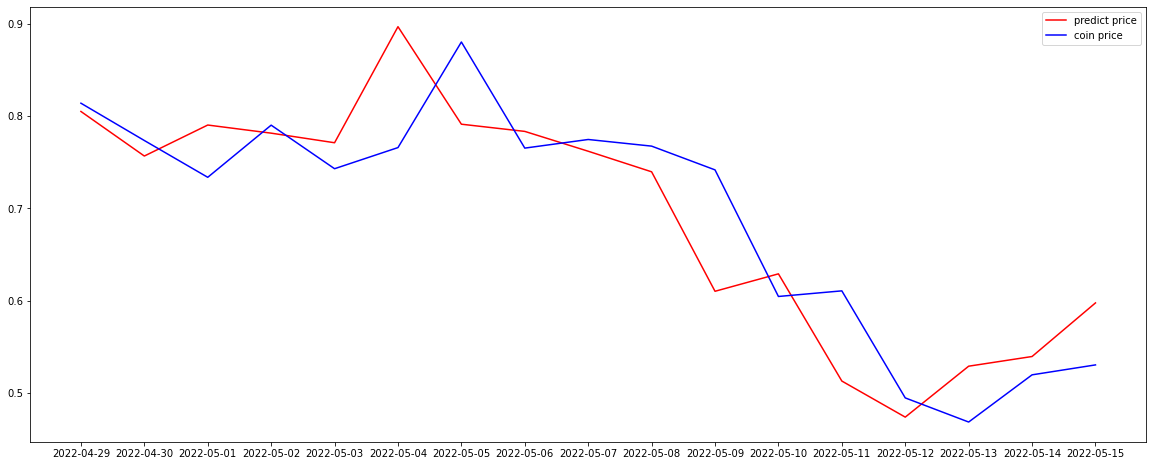

In [215]:
gfmodel.visualize()

In [216]:
result.to_csv('ADA_result_data')

In [217]:
result[['date','predict_close','vol','close','Greed_Fear_Score','target_date']].to_csv('ADA_Visulize_data.csv')